In [3]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [4]:
from utils import DataPreprocess, Parameters

Welcome to JupyROOT 6.18/00


In [5]:
import torch
from net import SNDNet, MyDataset, digitize_signal
device = torch.device("cuda", 0)

In [6]:
from matplotlib import pylab as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import time
from tqdm import tqdm
from IPython import display
import os
%matplotlib inline

In [7]:
params = Parameters("9X0")
data_preprocessor = DataPreprocess(params)

In [6]:
filename = "/home/shirobokov/data/SHIP_data/TT_data/9X0/9X0_500k.root"
showers_root = data_preprocessor.open_shower_file(filename, stop=500000)

Warning in <TClass::Init>: no dictionary for class ShipMCTrack is available
Warning in <TClass::Init>: no dictionary for class ShipRpcPoint is available
Warning in <TClass::Init>: no dictionary for class FairMCPoint is available
Warning in <TClass::Init>: no dictionary for class FairMultiLinkedData_Interface is available
Warning in <TClass::Init>: no dictionary for class FairMultiLinkedData is available
Warning in <TClass::Init>: no dictionary for class FairLink is available
Warning in <TClass::Init>: no dictionary for class TargetPoint is available
Warning in <TClass::Init>: no dictionary for class TTPoint is available
Warning in <TClass::Init>: no dictionary for class HptPoint is available
Warning in <TClass::Init>: no dictionary for class FairMCEventHeader is available
Warning in <TClass::Init>: no dictionary for class FairFileHeader is available


In [8]:
processed_file_path = "/home/shirobokov/data/SHIP_data/TT_data"

In [8]:
data_preprocessor.clean_data_and_save(showers_root, processed_file_path)

0 0 0
(500000, 8) (500000, 10)
(495316, 8)


In [9]:
TT_df = pd.read_pickle(os.path.join(processed_file_path, "tt_cleared.pkl"))
y_full = pd.read_pickle(os.path.join(processed_file_path, "y_cleared.pkl"))

(6, 150, 185)


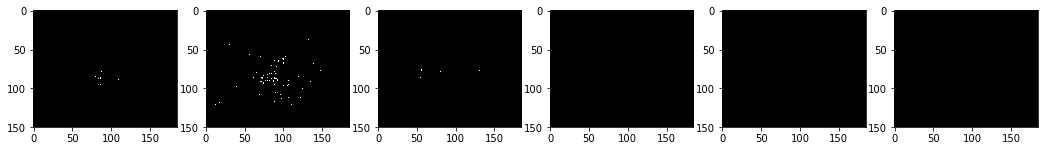

In [10]:
index=0
response = digitize_signal(TT_df.iloc[index], params=params, filters=6)
print(response.shape)
plt.figure(figsize=(18,6))
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(response[i].astype("uint8") * 255, cmap='gray')

# Train/test split

In [11]:
y = y_full[["E", "Z"]]
NORM = 7. / 100
y["E"] *= NORM

/mnt/shirobokov/conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
indeces = np.arange(len(TT_df))
train_indeces, test_indeces, _, _ = train_test_split(indeces, indeces, train_size=0.9, random_state=1543)


batch_size = 512
train_dataset = MyDataset(TT_df, y, params, train_indeces, n_filters=6)
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=10)

test_dataset = MyDataset(TT_df, y, params, test_indeces, n_filters=6)
test_batch_gen = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=batch_size,
                                              shuffle=False,
                                              num_workers=5)

In [13]:
test_indeces.shape

(49532,)

# Training

In [15]:
class Logger(object):
    def __init__(self):
        pass

    def plot_losses(self, epoch, num_epochs, start_time):
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
        ax1.set_title("Loss")
        ax1.set_xlabel("#Epoch")
        ax1.set_ylabel("loss")
        ax1.plot(train_loss, 'b', label='Train loss')
        ax1.legend(loc='best')
        ax1.grid()

        ax2.set_title("MSE error")
        ax2.set_xlabel("#Epoch")
        ax2.set_ylabel("E error")
        ax2.plot(val_accuracy_1, 'b', label='Test energy')

        ax3 = ax2.twinx()
        ax3.set_ylabel("Dist error")
        ax3.plot(val_accuracy_2, 'r', label='Test dist')
        ax2.legend(loc='upper right')
        ax3.legend(loc='lower left')
        ax2.grid()
        ax3.grid()

        plt.show()

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            train_loss[-1]))
        print("  validation Energy:\t\t{:.4f} %".format(val_accuracy_1[-1]))
        print("  validation distance:\t\t{:.4f} %".format(val_accuracy_2[-1]))        

In [16]:
net = SNDNet(n_input_filters=6).to(device)
logger = Logger()

lr = 1e-3
opt = torch.optim.Adam(net.model.parameters(), lr=lr, weight_decay=0.01)
num_epochs = 60

train_loss = []
val_accuracy_1 = []
val_accuracy_2 = []

In [16]:
def run_training(lr, num_epochs, opt):
    try:
        for epoch in range(num_epochs):
            # In each epoch, we do a full pass over the training data:
            start_time = time.time()
            net.model.train(True)

            epoch_loss = 0
            for X_batch, y_batch in tqdm(train_batch_gen, total = int(len(train_indeces) / batch_size)):
                # train on batch
                loss = net.compute_loss(X_batch, y_batch)
                loss.backward()
                opt.step()
                opt.zero_grad()
                epoch_loss += loss.item()

            train_loss.append(epoch_loss / (len(train_indeces) // batch_size + 1))


            y_score = []
            with torch.no_grad():
                for (X_batch, y_batch) in tqdm(test_batch_gen, total = int(len(test_indeces) / batch_size)):
                    logits = net.predict(X_batch)
                    y_pred = logits.cpu().detach().numpy()
                    y_score.extend(y_pred)

            y_score = mean_squared_error(y.iloc[test_indeces], np.asarray(y_score), multioutput='raw_values')
            val_accuracy_1.append(y_score[0])
            val_accuracy_2.append(y_score[1])    

            # Visualize
            display.clear_output(wait=True)
            logger.plot_losses(epoch, num_epochs, start_time)

            if (epoch + 1) % 10 == 0:
                with open(str(epoch) + "_9X0_coordconv.pt", 'wb') as f:
                    torch.save(net, f)       
                lr = lr / 2
                opt = torch.optim.Adam(net.model.parameters(), lr=lr)
    except KeyboardInterrupt:
        pass

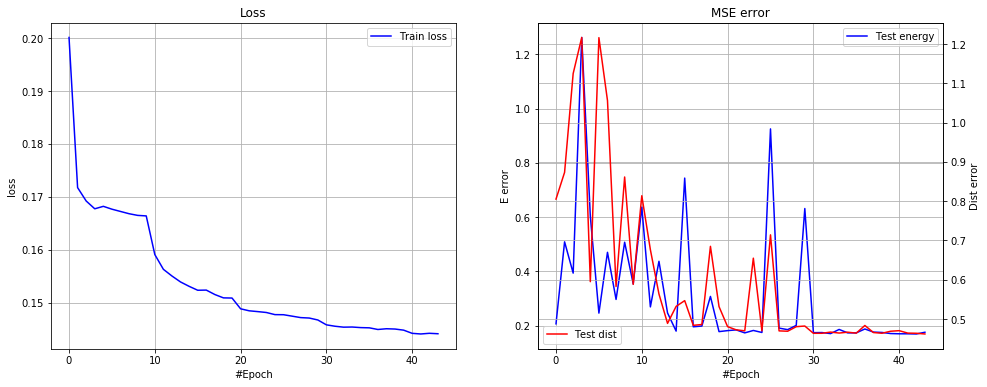

  0%|          | 0/870 [00:00<?, ?it/s]

Epoch 44 of 60 took 1530.320s
  training loss (in-iteration): 	0.144115
  validation Energy:		0.1761 %
  validation distance:		0.4619 %


 63%|██████▎   | 544/870 [15:05<08:54,  1.64s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 79%|███████▉  | 687/870 [19:01<04:58,  1.63s/it]

In [ ]:
run_training(lr, num_epochs, opt)

In [18]:
net = torch.load("59_9X0_coordconv.pt")

In [23]:
preds = []
with torch.no_grad():
    for (X_batch, y_batch) in tqdm(test_batch_gen, total = int(len(test_indeces) / batch_size)):
        preds.append(net.predict(X_batch))

97it [01:46,  1.02it/s]                        


In [37]:
ans = np.concatenate([p.detach().cpu().numpy() for p in preds])

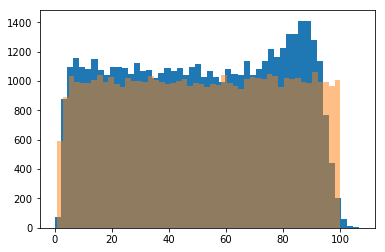

In [52]:
plt.hist(ans[:, 0] / NORM, bins=50, label='Pred');
plt.hist(y["E"][test_indeces] / NORM, bins=50, alpha=0.5, label='True');

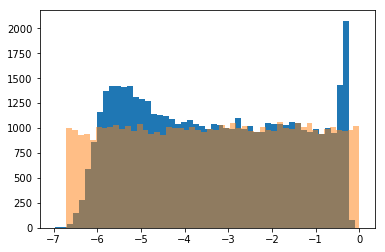

In [54]:
plt.hist(ans[:, 1], bins=50, label='Pred');
plt.hist(y["Z"][test_indeces], bins=50, alpha=0.5, label='True');